## 範例重點
* 了解如何在 Keras 中，加入 regularization
* 熟悉建立、訓練模型
* 熟悉將訓練結果視覺化並比較結果

In [1]:
## 確認硬體資源 (如果你是在 Linux, 若是在 Windows, 請參考 https://blog.csdn.net/idwtwt/article/details/78017565)
!nvidia-smi

'nvidia-smi' 不是內部或外部命令、可執行的程式或批次檔。


In [2]:
import os
import keras

# 本範例不需使用 GPU, 將 GPU 設定為 "無"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [3]:
# 從 Keras 的內建功能中，取得 train 與 test 資料集
train, test = keras.datasets.cifar10.load_data()

In [4]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [5]:
x_train, y_train = train
x_test, y_test = test

# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# 資料前處理 -Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [8]:
from keras.regularizers import l1, l2, l1_l2

"""
建立神經網路，並加入 L1 或 L2
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l2(l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l2(l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [9]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [10]:
results = {}
"""
使用迴圈建立不同的帶不同 L1/L2 的模型並訓練
"""
for regulizer_ratio in L2_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], l2_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Experiment with Regulizer = 0.010000
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Instructions for updati

Epoch 48/50
50000/50000 [==============================] - 9s 179us/step - loss: 1.6165 - acc: 0.5231 - val_loss: 1.6774 - val_acc: 0.5011
Epoch 49/50
50000/50000 [==============================] - 9s 179us/step - loss: 1.6141 - acc: 0.5248 - val_loss: 1.7061 - val_acc: 0.4846
Epoch 50/50
50000/50000 [==============================] - 9s 180us/step - loss: 1.6111 - acc: 0.5242 - val_loss: 1.6865 - val_acc: 0.4886
Experiment with Regulizer = 0.000100
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Den

50000/50000 [==============================] - 9s 180us/step - loss: 1.0192 - acc: 0.6920 - val_loss: 1.6708 - val_acc: 0.5023
Epoch 50/50
50000/50000 [==============================] - 9s 179us/step - loss: 1.0061 - acc: 0.6964 - val_loss: 1.5947 - val_acc: 0.5295
Experiment with Regulizer = 0.000000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 1

50000/50000 [==============================] - 10s 206us/step - loss: 1.4792 - acc: 0.4809 - val_loss: 1.5030 - val_acc: 0.4672
Epoch 10/50
50000/50000 [==============================] - 11s 223us/step - loss: 1.4555 - acc: 0.4874 - val_loss: 1.4793 - val_acc: 0.4782
Epoch 11/50
50000/50000 [==============================] - 11s 221us/step - loss: 1.4314 - acc: 0.4972 - val_loss: 1.4743 - val_acc: 0.4791
Epoch 12/50
50000/50000 [==============================] - 11s 223us/step - loss: 1.4092 - acc: 0.5037 - val_loss: 1.4526 - val_acc: 0.4889
Epoch 13/50
50000/50000 [==============================] - 10s 208us/step - loss: 1.3863 - acc: 0.5123 - val_loss: 1.4523 - val_acc: 0.4863
Epoch 14/50
50000/50000 [==============================] - 10s 200us/step - loss: 1.3683 - acc: 0.5158 - val_loss: 1.4376 - val_acc: 0.4922
Epoch 15/50
50000/50000 [==============================] - 10s 209us/step - loss: 1.3487 - acc: 0.5260 - val_loss: 1.4053 - val_acc: 0.5042
Epoch 16/50
50000/50000 [=======

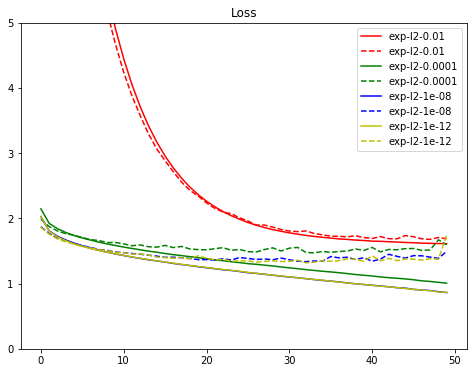

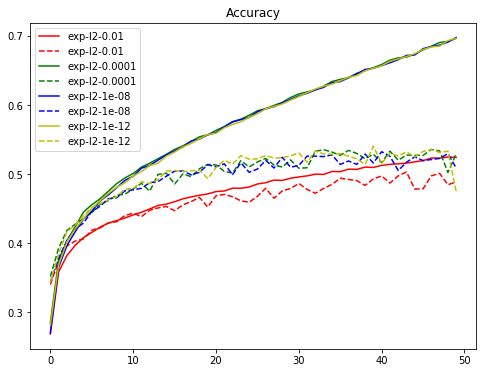

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [12]:
from keras.regularizers import l1, l2, l1_l2

"""
建立神經網路，並加入 L1 
"""
def build_l1_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1(l1_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1(l1_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [15]:
results_l1 = {}
"""
使用迴圈建立不同的帶不同 L1 的模型並訓練
"""
for regulizer_ratio in L2_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_l1_mlp(input_shape=x_train.shape[1:], l1_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l1-%s" % str(regulizer_ratio)
    results_l1[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Experiment with Regulizer = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [=====================

50000/50000 [==============================] - 10s 208us/step - loss: 3.4845 - acc: 0.5894 - val_loss: 3.6459 - val_acc: 0.5169
Epoch 32/50
50000/50000 [==============================] - 12s 240us/step - loss: 3.4302 - acc: 0.5915 - val_loss: 3.5887 - val_acc: 0.5258
Epoch 33/50
50000/50000 [==============================] - 11s 211us/step - loss: 2.7087 - acc: 0.6265 - val_loss: 2.9950 - val_acc: 0.5226
Epoch 49/50
50000/50000 [==============================] - 10s 202us/step - loss: 2.6653 - acc: 0.6307 - val_loss: 2.9849 - val_acc: 0.5120
Epoch 50/50
50000/50000 [==============================] - 10s 209us/step - loss: 2.6357 - acc: 0.6333 - val_loss: 2.9281 - val_acc: 0.5240
Experiment with Regulizer = 0.000000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_laye

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



50000/50000 [==============================] - 12s 230us/step - loss: 1.1497 - acc: 0.5966 - val_loss: 1.3581 - val_acc: 0.5239
Epoch 28/50
50000/50000 [==============================] - 12s 234us/step - loss: 1.1399 - acc: 0.5984 - val_loss: 1.3500 - val_acc: 0.5267
Epoch 29/50
50000/50000 [==============================] - 11s 230us/step - loss: 1.1231 - acc: 0.6051 - val_loss: 1.4339 - val_acc: 0.5029
Epoch 30/50
50000/50000 [==============================] - 11s 224us/step - loss: 1.1085 - acc: 0.6111 - val_loss: 1.4843 - val_acc: 0.4921
Epoch 31/50
50000/50000 [==============================] - 12s 232us/step - loss: 1.0958 - acc: 0.6126 - val_loss: 1.3480 - val_acc: 0.5233
Epoch 32/50
50000/50000 [==============================] - 10s 205us/step - loss: 1.0849 - acc: 0.6172 - val_loss: 1.3924 - val_acc: 0.5172ss: 1.0815
Epoch 33/50
50000/50000 [==============================] - 15s 294us/step - loss: 1.0701 - acc: 0.6244 - val_loss: 1.3586 - val_acc: 0.5283
Epoch 34/50
50000/5000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



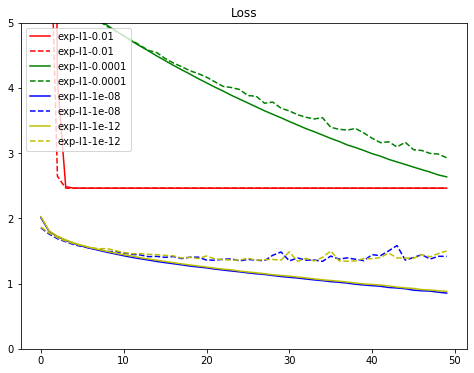

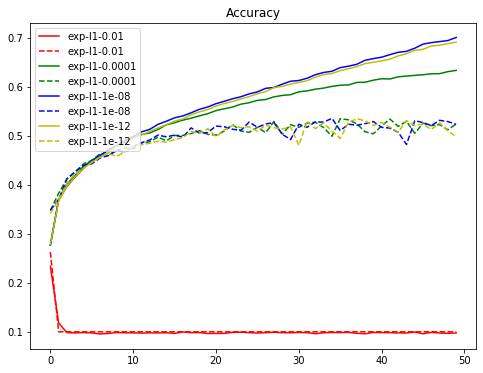

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results_l1.keys()):
    plt.plot(range(len(results_l1[cond]['train-loss'])),results_l1[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results_l1[cond]['valid-loss'])),results_l1[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results_l1.keys()):
    plt.plot(range(len(results_l1[cond]['train-acc'])),results_l1[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results_l1[cond]['valid-acc'])),results_l1[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()